# Setting

## Libraries

In [1]:
library(quantmod)
library(forecast)
library(rugarch)

Loading required package: xts

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: TTR

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Loading required package: parallel


Attaching package: ‘rugarch’


The following object is masked from ‘package:stats’:

    sigma




In [2]:
library(prophet)
library(dplyr)

library(bsts)

Loading required package: Rcpp

Loading required package: rlang


Attaching package: ‘dplyr’


The following objects are masked from ‘package:xts’:

    first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: BoomSpikeSlab

Loading required package: Boom

Loading required package: MASS


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select



Attaching package: ‘Boom’


The following object is masked from ‘package:stats’:

    rWishart



Attaching package: ‘BoomSpikeSlab’


The following object is masked from ‘package:stats’:

    knots



Attaching package: ‘bsts’


The following object is masked from ‘package:BoomSpikeSlab’:

    SuggestBurn



Attaching package: ‘xgboost’


The following object is masked from ‘package:dplyr’:

    slice




### user's defined

In [3]:
path <- '~/works/utils/r'
source(paste(path, "myutils.r", sep='/'))
source(paste(path, "myarimagarch.r", sep='/'))

In [4]:
new.get_result <- function(x, group, group.col='Models',
                          #errors=c('rmse','mape'), # unconditional forecast
                          errors=c('rmse.mean','mape.mean') # daily forecast
                          ) 
{
    y <- my.get_result(x, group, errors=errors, group.col=group.col)
    colnames(y) <- c('rmse','mape',group.col)
    return(y)
}

new.plot_errors <- function(x, group.col='Models', ...) {
    my.plot_errors(x, metrics=c('rmse'), group.col=group.col, ...)
}

## Data

### S&P 500

In [4]:
train_start <- '1991-01-01'
train_end <- '2019-12-31'

test_start <- '2020-01-01'
test_end <- '2020-12-31'

In [5]:
from <- train_start
to <- test_end
getSymbols("^GSPC", from=from, to=to)

[1] "^GSPC"

In [6]:
spx <- GSPC
colnames(spx) <- c('o','h','l','c','v','a')

### Return

In [7]:
lookahead <- 21

In [8]:
spx.ret <- diff(log(spx$a), lookahead)
spx.ret <- na.omit(spx.ret)
colnames(spx.ret) <- 'logret'
head(spx.ret)

               logret
1991-01-31 0.05216129
1991-02-01 0.06360416
1991-02-04 0.08173788
1991-02-05 0.10755822
1991-02-06 0.12847341
1991-02-07 0.13502311

In [9]:
train <- window(spx.ret, end=as.Date(train_end))
test <- window(spx.ret, start=as.Date(test_start), end=as.Date(test_end))

## CV Settings

In [10]:
YEAR <- 252

#hori <- floor(YEAR/2)
#hori <- floor(YEAR/6)
hori <- floor(YEAR/12)

#peri <- floor(hori/2)
#peri <- hori*2
peri <- hori

#wind <- 5*YEAR
#wind <- 7*YEAR
wind <- 9*YEAR

### testing
- rerun Regressors

In [11]:
train_start <- '1991-01-01'
train_end <- '2000-12-31'
#train_end <- '1998-12-31'
#train_end <- '1997-12-31'
train <- window(spx.ret, start=as.Date(train_start), end=as.Date(train_end))

In [11]:
sample.r <- 0.1
#sample.r <- 0.05

n <- (nrow(train) - wind - hori)/floor(peri) * round(hori * sample.r)
print(paste('number of iterations: ', round(n), sep=''))

[1] "number of iterations: 476"


## Regressors

In [12]:
x <- RSI(spx$a)
trainx <- merge(train, x, join='left', fill=NA)

In [13]:
# use close instead of adjusted to make consistent with "un-adjusted" high & low
x <- BBands(spx[,c('h','l','c')])
x <- x$pctB
trainx <- merge(trainx, x, join='left', fill=NA)

In [14]:
x <- MACD(spx$a)
x <- x$macd - x$signal
trainx <- merge(trainx, x, join='left', fill=NA)

In [15]:
colnames(trainx) <- c('y','rsi','bbands','macd')
trainx <- na.omit(trainx)
head(trainx)
tail(trainx)

                    y      rsi    bbands        macd
1991-02-19 0.10602550 72.59254 0.8419486 -0.03641515
1991-02-20 0.09798126 66.25313 0.7706927 -0.18551057
1991-02-21 0.10585688 66.00481 0.7330987 -0.30953562
1991-02-22 0.10194779 66.54491 0.7402938 -0.39546732
1991-02-25 0.09259647 67.84742 0.7305630 -0.43573971
1991-02-26 0.07655978 60.80133 0.6379610 -0.55105032

                    y      rsi    bbands       macd
2019-12-23 0.03808252 76.15462 0.9680588 0.15430304
2019-12-24 0.03571448 75.83204 0.9028770 0.14089335
2019-12-26 0.03335029 78.41506 0.9189083 0.14916039
2019-12-27 0.03119111 78.43159 0.8946206 0.13732115
2019-12-30 0.02122778 68.77901 0.7837726 0.07574999
2019-12-31 0.02818876 70.74366 0.7500170 0.04243151

# Prophet

## Setting

In [290]:
cv.forecast <- function(x, h, xreg=NULL, xreg.msize=NULL, result.error=TRUE) {
    
    check.ds <- function(x) {
        d <- try(as.POSIXct(x$ds, format = "%Y-%m-%d"), silent=T)
        if ((sum(is.na(d))>0) | (is.element("try-error", class(d))))  {
            #print("That wasn't correct!")
            x$ds <- seq(as.Date('1901-01-01'), length.out=length(x$ds), by=1)
        }
        return(x)
    }
    
    model <- prophet()

    if (!is.null(xreg)) {
        ### convert data for prophet
        #x <- ifelse(is.null(dim(x)), data.frame(x), x) # not works
        if (is.null(dim(x))) {x <- data.frame(x)}
        colnames(x) <- 'y'
        x.train <- cbind(x, xreg)
        x.train <- as.data.frame(x.train)
        x.train <- cbind(ds=rownames(x.train), x.train)
        rownames(x.train) <- NULL
        x.train <- check.ds(x.train)

        ### add regressors before fitting
        for (c in colnames(xreg)) {
            model <- add_regressor(model, c)
        }

        ### fit: must run after add_regressor and before make_future_dataframe
        model <- fit.prophet(model, x.train)

        ### prepare future ds
        future <- make_future_dataframe(model, periods=h)

        # regessor assumption for future
        if (is.null(xreg.msize)) {
            xreg.m <- xreg # calc mean for future with all the xreg
        } else {
            # calc mean for future with xreg of length xreg.mszie
            xreg.m <- tail(xreg, n=xreg.msize)
        }
        
        if (is.null(dim(xreg))) {
            xreg.h <- mean(xreg.m)
        } else {
            xreg.h <- colMeans(xreg.m)  
        }

        # rbind history & future of xreg
        xreg.all <- data.frame(xreg)
        xreg.coln <- colnames(xreg.all) # save name for the case of single xreg

        xreg.h <- data.frame(xreg.h)
        colnames(xreg.h) <- colnames(NA)
        xreg.h <- t(xreg.h)
        xreg.h <- as.ts(xreg.h[rep(seq_len(nrow(xreg.h)), h), ])
        xreg.h <- data.frame(xreg.h) # convert to frame for the case of single xreg
        
        # update future
        if ((dim(xreg.h)[2]==1) & (dim(xreg.h)[1]==length(xreg.coln))) {
            xreg.h <- t(xreg.h) # the case of h==1
        }
        colnames(xreg.h) <- xreg.coln # match name to rbind
        #xreg.all <- rbind(xreg.all, xreg.h)
        xreg.all <- rbind(as.matrix(xreg.all), xreg.h) 
        xreg.all <- data.frame(xreg.all, row.names = NULL) 
        xreg.all$ds <- future$ds
        future <- xreg.all

    } else {
        x.train <- data.frame(ds=index(x), y=as.numeric(x))
        x.train <- check.ds(x.train)
        model <- fit.prophet(model, x.train)
        future <- make_future_dataframe(model, periods=h)
    }

    fc <- predict(model, future)
    if (result.error) {
        fc <- list(method = "Prophet Forecasting", mean=tail(fc$yhat, h))
    } else {
        fc <- list(model=model, pred=fc)
    }
    return(fc)
} 

prophet.forecast <- cv.forecast

In [19]:
# Calc error of prediction of sample.n selected from h period 
cv.forecast.2 <- function(x, h, xreg=NULL, xreg.msize=NULL, sample.n=0) 
{
    result.rmse <- c()
    result.mape <- c()
    train.len <- length(x) - h
    my.subset <- function(x, s, e) {
        if (!is.null(x)) {
            #x <- subset(x, start=s, end=e)
            #x <- subset(as.ts(x), start=s, end=e)
            x <- subset(ts(x), start=s, end=e)
        }
        return(x)
    }
    idx <- 0:(h-1)
    if ((sample.n>0) & (sample.n<h)) {
        idx <- sort(sample(idx, sample.n))
    }
    for (i in seq_along(idx)) {
        trlen <- train.len+idx[i]
        x.train <- my.subset(x, 1, trlen)
        xreg.train <- my.subset(xreg, 1, trlen)
        fc <- cv.forecast(x.train, 1, xreg=xreg.train, xreg.msize=xreg.msize)
        result.rmse[i] <- sqrt(mean((fc$mean - x[trlen+1])^2))
        result.mape[i] <- mean(abs(1 - fc$mean / x[trlen+1]))
    }
    e <- list(rmse.mean=mean(result.rmse), rmse.sigma=sd(result.rmse), 
              mape.mean=mean(result.mape), mape.sigma=sd(result.mape))
    return(e)
} 

## Basic

In [20]:
result.m01.1 <- my.tsCV.2(train, cv.forecast.2, h=hori, window=wind, step=peri,
                          silent=F,
                          sample.n=round(hori*sample.r))

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run

[1] "10 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run

[1] "20 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run

[1] "30 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run

[1] "40 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run

[1] "50 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run

[1] "60 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run

[1] "70 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run

[1] "80 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run

[1] "90 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run

In [21]:
x <- result.m01.1
from <- na.omit(x[,1])[1]
from <- index(train[from])
print(paste('cv starts from', from, sep=' '))

[1] "cv starts from 2000-01-24"


## Additional regressors

In [22]:
result.m01.2 <- my.tsCV.2(trainx[,1], cv.forecast.2, h=hori, window=wind, step=peri,
                          xreg=trainx[,2:4], 
                          sample.n=round(hori*sample.r),
                          silent=F)

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run

[1] "10 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run

[1] "20 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run

[1] "30 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run

[1] "40 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run

[1] "50 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run

[1] "60 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run

[1] "70 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run

[1] "80 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run

[1] "90 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run

In [23]:
result.m01.3 <- my.tsCV.2(trainx[,1], cv.forecast.2, h=hori, window=wind, step=peri,
                          xreg=trainx[,3], 
                          silent=F,
                          sample.n=round(hori*sample.r))

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run

[1] "10 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run

[1] "20 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run

[1] "30 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run

[1] "40 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run

[1] "50 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run

[1] "60 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run

[1] "70 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run

[1] "80 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run

[1] "90 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run

In [24]:
result.m01.4 <- my.tsCV.2(trainx[,1], cv.forecast.2, h=hori, window=wind, step=peri,
                         xreg=trainx[,2:4], 
                         sample.n=round(hori*sample.r),
                         xreg.msize=hori)

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run

[1] "10 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run

[1] "20 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run

[1] "30 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run

[1] "40 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run

[1] "50 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run

[1] "60 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run

[1] "70 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run

[1] "80 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run

[1] "90 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run

## Compare Errors

In [19]:
my.figsize(10,6)

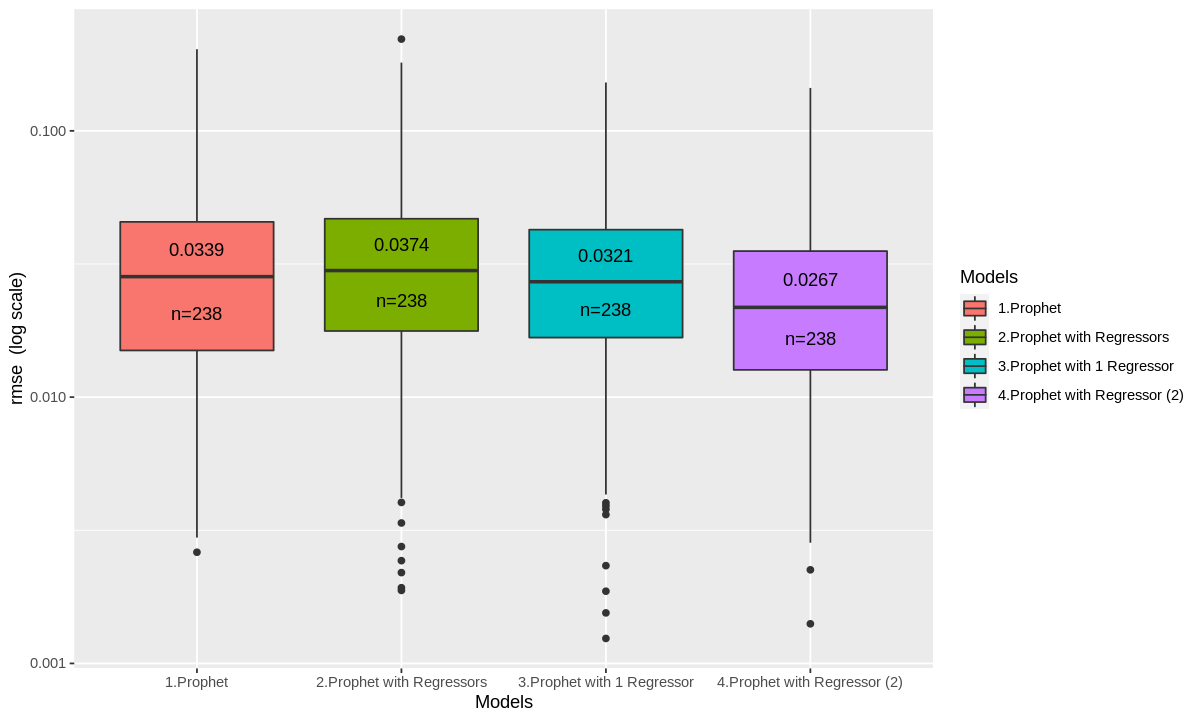

In [20]:
errors.1 <- new.get_result(result.m01.1, '1.Prophet')
errors.2 <- new.get_result(result.m01.2, '2.Prophet with Regressors')
errors.3 <- new.get_result(result.m01.3, '3.Prophet with 1 Regressor')
errors.4 <- new.get_result(result.m01.4, '4.Prophet with Regressor (2)')

x <- rbind(errors.1, errors.2)
x <- rbind(x, errors.3)
x <- rbind(x, errors.4)
new.plot_errors(x, ylog=T)

### save result

In [ ]:
x <- result.m01.1
write.csv(x, file = "prophet_result_m0101.csv")
x <- result.m01.2
write.csv(x, file = "prophet_result_m0102.csv")
x <- result.m01.3
write.csv(x, file = "prophet_result_m0103.csv")
x <- result.m01.4
write.csv(x, file = "prophet_result_m0104.csv")

### load result

In [17]:
result.m01.1 <- read.csv(file = 'prophet_result_m0101.csv')
result.m01.2 <- read.csv(file = 'prophet_result_m0102.csv')
result.m01.3 <- read.csv(file = 'prophet_result_m0103.csv')
result.m01.4 <- read.csv(file = 'prophet_result_m0104.csv')

In [21]:
result.m01 <- result.m01.4

# BSTS

## Setting

In [52]:
cv.forecast <- function(x, h, xreg=NULL, xreg.msize=NULL, expected.model.size=0,
                        model=NULL, niter=1000) 
{
    if (!is.null(xreg)) {
        ### set params for fitting
        # organize data for fitting
        if (is.null(dim(x))) {x <- data.frame(x)}
        colnames(x) <- 'y'
        x.train <- cbind(x, xreg)
        x.train <- as.data.frame(x.train)
        
        if (is.null(model)) {
            n <- ncol(x.train)
            if ((expected.model.size < 1) | (expected.model.size > n)) {
                expected.model.size <- n
            }
            ss <- AddSemilocalLinearTrend(list(), x.train$y)
            model <- bsts(y ~ .,
                          state.specification = ss,
                          niter = niter,
                          data = x.train,
                          expected.model.size = expected.model.size)  # Passed to SpikeSlabPrior.
            olddata <- NULL
        } else {
            olddata <- x.train
        }
        
        ### set params for prediction
        # regessor assumption for future
        if (is.null(xreg.msize)) {
            xreg.m <- xreg # calc mean for future with all the xreg
        } else {
            # calc mean for future with xreg of length xreg.mszie
            xreg.m <- tail(xreg, n=xreg.msize)
        }

        if (is.null(dim(xreg))) {
            xreg.h <- mean(xreg.m)
        } else {
            xreg.h <- colMeans(xreg.m)  
        }

        xreg.all <- data.frame(xreg)
        xreg.coln <- colnames(xreg.all) # save name for the case of single xreg
        xreg.h <- data.frame(xreg.h)
        colnames(xreg.h) <- colnames(NA)
        xreg.h <- t(xreg.h)
        xreg.h <- as.ts(xreg.h[rep(seq_len(nrow(xreg.h)), h), ])
        xreg.h <- data.frame(xreg.h) # convert to frame for the case of single xreg
        
        if ((dim(xreg.h)[2]==1) & (dim(xreg.h)[1]==length(xreg.coln))) {
            xreg.h <- t(xreg.h) # the case of h==1
        } else {
            xreg.h <- as.ts(xreg.h) # convert to ts as xreg is ts
        }
        
        colnames(xreg.h) <- xreg.coln # match name to rbind
        
    } else {
        if (is.null(model)) {
            ss <- AddSemilocalLinearTrend(list(), x)
            model <- bsts(x, state.specification = ss, niter=niter)
            olddata <- NULL
        } else {
            olddata <- x
        }
        xreg.h <- NULL
    }
    # predict
    fc <- predict(model, horizon=h, newdata=xreg.h, olddata=olddata)
    fc$model <- model
    return(fc)
}

bsts.forecast <- cv.forecast

In [18]:
# main difference with cv.forecast is that cv.forecase.2 need data for forecasting
cv.forecast.2 <- function(x, h, xreg=NULL, xreg.msize=NULL, sample.n=0) 
{
    result.rmse <- c()
    result.mape <- c()
    train.len <- length(x) - h
    my.subset <- function(x, s, e) {
        if (!is.null(x)) {
            x <- subset(ts(x), start=s, end=e)
        }
        return(x)
    }
    idx <- 0:(h-1)
    if ((sample.n>0) & (sample.n<h)) {
        idx <- sort(sample(idx, sample.n))
    }
    
    model <- NULL
    for (i in seq_along(idx)) {
        trlen <- train.len+idx[i]
        x.train <- my.subset(x, 1, trlen)
        xreg.train <- my.subset(xreg, 1, trlen)
        
        fc <- cv.forecast(x.train, 1, xreg=xreg.train, xreg.msize=xreg.msize, 
                          #expected.model.size=0,
                          model=model, niter=1000) 
        
        if (i==1) { # reuse model for the rest of periods
            model <- fc$model
        }
        
        result.rmse[i] <- sqrt(mean((fc$mean - x[trlen+1])^2))
        result.mape[i] <- mean(abs(1 - fc$mean / x[trlen+1]))
    }
    e <- list(rmse.mean=mean(result.rmse), rmse.sigma=sd(result.rmse), 
              mape.mean=mean(result.mape), mape.sigma=sd(result.mape))
    return(e)
} 

## Basic

In [39]:
result.m02.1 <- my.tsCV.2(train, cv.forecast.2, h=hori, window=wind, step=peri,
                          sample.n=round(hori*sample.r))

=-=-=-=-= Iteration 0 Thu Sep 22 01:49:20 2022 =-=-=-=-=
=-=-=-=-= Iteration 100 Thu Sep 22 01:49:23 2022 =-=-=-=-=
=-=-=-=-= Iteration 200 Thu Sep 22 01:49:26 2022 =-=-=-=-=
=-=-=-=-= Iteration 300 Thu Sep 22 01:49:30 2022 =-=-=-=-=
=-=-=-=-= Iteration 400 Thu Sep 22 01:49:33 2022 =-=-=-=-=
=-=-=-=-= Iteration 500 Thu Sep 22 01:49:36 2022 =-=-=-=-=
=-=-=-=-= Iteration 600 Thu Sep 22 01:49:39 2022 =-=-=-=-=
=-=-=-=-= Iteration 700 Thu Sep 22 01:49:42 2022 =-=-=-=-=
=-=-=-=-= Iteration 800 Thu Sep 22 01:49:45 2022 =-=-=-=-=
=-=-=-=-= Iteration 900 Thu Sep 22 01:49:48 2022 =-=-=-=-=
[1] "8 % done."
=-=-=-=-= Iteration 0 Thu Sep 22 01:49:51 2022 =-=-=-=-=
=-=-=-=-= Iteration 100 Thu Sep 22 01:49:54 2022 =-=-=-=-=
=-=-=-=-= Iteration 200 Thu Sep 22 01:49:57 2022 =-=-=-=-=
=-=-=-=-= Iteration 300 Thu Sep 22 01:50:00 2022 =-=-=-=-=
=-=-=-=-= Iteration 400 Thu Sep 22 01:50:03 2022 =-=-=-=-=
=-=-=-=-= Iteration 500 Thu Sep 22 01:50:06 2022 =-=-=-=-=
=-=-=-=-= Iteration 600 Thu Sep 22 01:50:09 

In [42]:
x <- result.m02.1
from <- na.omit(x[,1])[1]
from <- index(train[from])
print(paste('cv starts from', from, sep=' '))

[1] "cv starts from 2000-01-24"


## Regression with spike and slab priors

In [19]:
result.m02.2 <- my.tsCV.2(trainx[,1], cv.forecast.2, h=hori, window=wind, step=peri,
                          xreg=trainx[,2:4], 
                          silent=F,
                          sample.n=round(hori*sample.r))

=-=-=-=-= Iteration 0 Thu Sep 22 12:54:52 2022 =-=-=-=-=
=-=-=-=-= Iteration 100 Thu Sep 22 12:54:56 2022 =-=-=-=-=
=-=-=-=-= Iteration 200 Thu Sep 22 12:54:59 2022 =-=-=-=-=
=-=-=-=-= Iteration 300 Thu Sep 22 12:55:03 2022 =-=-=-=-=
=-=-=-=-= Iteration 400 Thu Sep 22 12:55:06 2022 =-=-=-=-=
=-=-=-=-= Iteration 500 Thu Sep 22 12:55:10 2022 =-=-=-=-=
=-=-=-=-= Iteration 600 Thu Sep 22 12:55:13 2022 =-=-=-=-=
=-=-=-=-= Iteration 700 Thu Sep 22 12:55:17 2022 =-=-=-=-=
=-=-=-=-= Iteration 800 Thu Sep 22 12:55:21 2022 =-=-=-=-=
=-=-=-=-= Iteration 900 Thu Sep 22 12:55:24 2022 =-=-=-=-=
=-=-=-=-= Iteration 0 Thu Sep 22 12:55:35 2022 =-=-=-=-=
=-=-=-=-= Iteration 100 Thu Sep 22 12:55:39 2022 =-=-=-=-=
=-=-=-=-= Iteration 200 Thu Sep 22 12:55:42 2022 =-=-=-=-=
=-=-=-=-= Iteration 300 Thu Sep 22 12:55:45 2022 =-=-=-=-=
=-=-=-=-= Iteration 400 Thu Sep 22 12:55:49 2022 =-=-=-=-=
=-=-=-=-= Iteration 500 Thu Sep 22 12:55:52 2022 =-=-=-=-=
=-=-=-=-= Iteration 600 Thu Sep 22 12:55:56 2022 =-=-=-=-=
=

In [20]:
x <- result.m02.2
from <- x[!is.na(x[,'forecast_start']),][,1][1]
from <- index(trainx[from])
print(paste('cv starts from', from, sep=' '))

[1] "cv starts from 2000-02-09"


In [21]:
result.m02.3 <- my.tsCV.2(trainx[,1], cv.forecast.2, h=hori, window=wind, step=peri,
                        xreg=trainx[,2:4], silent=F,
                        xreg.msize=hori,
                        sample.n=round(hori*sample.r))

=-=-=-=-= Iteration 0 Thu Sep 22 15:36:45 2022 =-=-=-=-=
=-=-=-=-= Iteration 100 Thu Sep 22 15:36:48 2022 =-=-=-=-=
=-=-=-=-= Iteration 200 Thu Sep 22 15:36:51 2022 =-=-=-=-=
=-=-=-=-= Iteration 300 Thu Sep 22 15:36:55 2022 =-=-=-=-=
=-=-=-=-= Iteration 400 Thu Sep 22 15:36:58 2022 =-=-=-=-=
=-=-=-=-= Iteration 500 Thu Sep 22 15:37:02 2022 =-=-=-=-=
=-=-=-=-= Iteration 600 Thu Sep 22 15:37:05 2022 =-=-=-=-=
=-=-=-=-= Iteration 700 Thu Sep 22 15:37:08 2022 =-=-=-=-=
=-=-=-=-= Iteration 800 Thu Sep 22 15:37:12 2022 =-=-=-=-=
=-=-=-=-= Iteration 900 Thu Sep 22 15:37:15 2022 =-=-=-=-=
=-=-=-=-= Iteration 0 Thu Sep 22 15:37:25 2022 =-=-=-=-=
=-=-=-=-= Iteration 100 Thu Sep 22 15:37:28 2022 =-=-=-=-=
=-=-=-=-= Iteration 200 Thu Sep 22 15:37:32 2022 =-=-=-=-=
=-=-=-=-= Iteration 300 Thu Sep 22 15:37:35 2022 =-=-=-=-=
=-=-=-=-= Iteration 400 Thu Sep 22 15:37:39 2022 =-=-=-=-=
=-=-=-=-= Iteration 500 Thu Sep 22 15:37:42 2022 =-=-=-=-=
=-=-=-=-= Iteration 600 Thu Sep 22 15:37:46 2022 =-=-=-=-=
=

## Compare Errors

In [18]:
my.figsize(10,6)

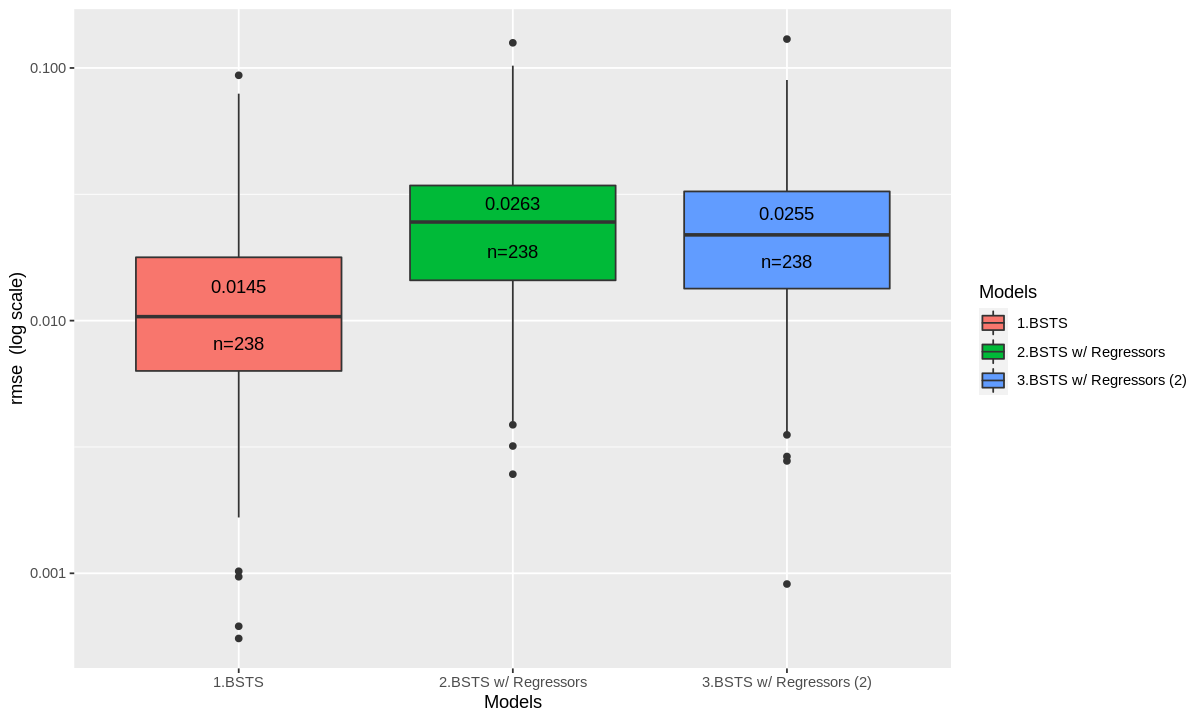

In [23]:
errors.1 <- new.get_result(result.m02.1, '1.BSTS')
errors.2 <- new.get_result(result.m02.2, '2.BSTS w/ Regressors')
errors.3 <- new.get_result(result.m02.3, '3.BSTS w/ Regressors (2)')

#x <- errors.1
x <- rbind(errors.1, errors.2)
x <- rbind(x, errors.3)

new.plot_errors(x, ylog=T)

In [24]:
result.m02 <- result.m02.1

### save result

In [27]:
#x <- result.m02.1
#write.csv(x, file = "bsts_result_m0201.csv")
x <- result.m02.2
write.csv(x, file = "bsts_result_m0202.csv")
x <- result.m02.3
write.csv(x, file = "bsts_result_m0203.csv")

### load result

In [22]:
result.m02.1 <- read.csv(file = 'bsts_result_m0201.csv')
result.m02.2 <- read.csv(file = 'bsts_result_m0202.csv')
result.m02.3 <- read.csv(file = 'bsts_result_m0203.csv')

# ARIMA

## Setting

In [17]:
cv.forecast <- function(x, h, xreg=NULL, xreg.msize=NULL, order=NULL) {
    
    if (!is.null(xreg)) {
        
        if (is.null(xreg.msize)) {
            xreg.m <- xreg # calc mean for future with all the xreg
        } else {
            # calc mean for future with xreg of length xreg.mszie
            xreg.m <- tail(xreg, n=xreg.msize)
        }
        
        if (is.null(dim(xreg))) {
            xreg.h <- mean(xreg.m)
        } else {
            xreg.h <- colMeans(xreg.m)  
        }
        
        xreg.h <- data.frame(xreg.h)
        colnames(xreg.h) <- colnames(NA)
        #colnames(xreg.h) <- colnames(xreg) # error with multiple xreg
        xreg.h <- t(xreg.h)
        xreg.h <- as.ts(xreg.h[rep(seq_len(nrow(xreg.h)), h), ])
        
        ## added for single day forecast
        xreg.coln <- colnames(xreg)
        xreg.h <- data.frame(xreg.h) # convert to frame for the case of single xreg
        if ((dim(xreg.h)[2]==1) & (dim(xreg.h)[1]==length(xreg.coln))) {
            xreg.h <- t(xreg.h) # the case of h==1
        } else {
            xreg.h <- as.ts(xreg.h) # convert to ts as xreg is ts
        }
        
    } else {
        xreg.h <- NULL
    }
    if (is.null(order)) {
        fc <- forecast(auto.arima(x, trace=TRUE, ic='aicc', seasonal=FALSE, 
                                  xreg=xreg, 
                                  #lambda="auto" # not for negative value
                                  ), h=h, xreg=xreg.h)
    } else {
        fc <- forecast(Arima(x, order=order, seasonal=FALSE, 
                                  xreg=xreg, 
                                  ), h=h, xreg=xreg.h)
    }
    return(fc)
}

arima.forecast <- cv.forecast

In [18]:
# main difference with cv.forecast is that cv.forecase.2 need data for forecasting
cv.forecast.2 <- function(x, h, xreg=NULL, xreg.msize=NULL, sample.n=0) 
{
    result.rmse <- c()
    result.mape <- c()
    train.len <- length(x) - h
    my.subset <- function(x, s, e) {
        if (!is.null(x)) {
            #x <- subset(x, start=s, end=e)
            #x <- subset(as.ts(x), start=s, end=e)
            x <- subset(ts(x), start=s, end=e)
        }
        return(x)
    }
    idx <- 0:(h-1)
    if ((sample.n>0) & (sample.n<h)) {
        idx <- sort(sample(idx, sample.n))
    }
    
    order <- NULL
    for (i in seq_along(idx)) {
        trlen <- train.len+idx[i]
        x.train <- my.subset(x, 1, trlen)
        xreg.train <- my.subset(xreg, 1, trlen)
        
        fc <- cv.forecast(x.train, 1, xreg=xreg.train, xreg.msize=xreg.msize,
                          order=order)
        if (i==1) { # reuse param for the rest of periods
            p <- fc$model$arma[1]
            d <- fc$model$arma[6]
            q <- fc$model$arma[2]
            order <- c(p, d, q)
        }
        
        result.rmse[i] <- sqrt(mean((fc$mean - x[trlen+1])^2))
        result.mape[i] <- mean(abs(1 - fc$mean / x[trlen+1]))
    }
    e <- list(rmse.mean=mean(result.rmse), rmse.sigma=sd(result.rmse), 
              mape.mean=mean(result.mape), mape.sigma=sd(result.mape))
    return(e)
} 

## Basic

In [19]:
result.m03.1 <- my.tsCV.2(train, cv.forecast.2, h=hori, window=wind, step=peri, 
                          silent=T,
                          sample.n=round(hori*sample.r))


 Fitting models using approximations to speed things up...

 ARIMA(2,0,2) with non-zero mean : Inf
 ARIMA(0,0,0) with non-zero mean : -8729.901
 ARIMA(1,0,0) with non-zero mean : -13486.9
 ARIMA(0,0,1) with non-zero mean : -10820.55
 ARIMA(0,0,0) with zero mean     : -8407.697
 ARIMA(2,0,0) with non-zero mean : -13491.63
 ARIMA(3,0,0) with non-zero mean : -13491.75
 ARIMA(4,0,0) with non-zero mean : -13496.44
 ARIMA(5,0,0) with non-zero mean : -13502.01
 ARIMA(5,0,1) with non-zero mean : -13509.96
 ARIMA(4,0,1) with non-zero mean : -13504.29
 ARIMA(5,0,2) with non-zero mean : -13507.99
 ARIMA(4,0,2) with non-zero mean : -13508.66
 ARIMA(5,0,1) with zero mean     : -13497.02

 Now re-fitting the best model(s) without approximations...

 ARIMA(5,0,1) with non-zero mean : -13497.21

 Best model: ARIMA(5,0,1) with non-zero mean 


 Fitting models using approximations to speed things up...

 ARIMA(2,1,2) with drift         : Inf
 ARIMA(0,1,0) with drift         : -13377.54
 ARIMA(1,1,0) wi

In [20]:
x <- result.m03.1
from <- na.omit(x[,1])[1]
from <- index(train[from])
print(paste('cv starts from', from, sep=' '))

[1] "cv starts from 2000-01-24"


## Regression with ARIMA errors

In [21]:
result.m03.2 <- my.tsCV.2(trainx[,1], cv.forecast.2, h=hori, window=wind, step=peri,
                      silent=F,
                      xreg=trainx[,2:4],
                      sample.n=round(hori*sample.r))


 Fitting models using approximations to speed things up...

 Regression with ARIMA(2,1,2) errors : -14728.24
 Regression with ARIMA(0,1,0) errors : -14705.76
 Regression with ARIMA(1,1,0) errors : -14703.21
 Regression with ARIMA(0,1,1) errors : -14703.85
 Regression with ARIMA(0,1,0) errors : -14707.74
 Regression with ARIMA(1,1,2) errors : -14755.07
 Regression with ARIMA(0,1,2) errors : -14703.58
 Regression with ARIMA(1,1,1) errors : -14701.2
 Regression with ARIMA(1,1,3) errors : -14756.2
 Regression with ARIMA(0,1,3) errors : -14715.69
 Regression with ARIMA(2,1,3) errors : -14743.68
 Regression with ARIMA(1,1,4) errors : -14754.84
 Regression with ARIMA(0,1,4) errors : -14713.96
 Regression with ARIMA(2,1,4) errors : -14742.53
 Regression with ARIMA(1,1,3) errors : -14757.92
 Regression with ARIMA(0,1,3) errors : -14717.66
 Regression with ARIMA(1,1,2) errors : -14756.77
 Regression with ARIMA(2,1,3) errors : -14745.4
 Regression with ARIMA(1,1,4) errors : -14756.51
 Regression

In [22]:
x <- result.m03.2
from <- na.omit(x[,1])[1]
from <- index(train[from])
print(paste('cv starts from', from, sep=' '))

[1] "cv starts from 2000-01-24"


## Regressor mean of smaller period for forecast 
- Regressor mean for forecast is calculated from the number of latest 'horizon' period
- the 1st model used the number of latest 'window' period for the calc of regressor mean

In [23]:
result.m03.3 <- my.tsCV.2(trainx[,1], cv.forecast.2, h=hori, window=wind, step=peri,
                      xreg.msize=hori,
                      xreg=trainx[,2:4],
                      sample.n=round(hori*sample.r))


 Fitting models using approximations to speed things up...

 Regression with ARIMA(2,1,2) errors : -14728.24
 Regression with ARIMA(0,1,0) errors : -14705.76
 Regression with ARIMA(1,1,0) errors : -14703.21
 Regression with ARIMA(0,1,1) errors : -14703.85
 Regression with ARIMA(0,1,0) errors : -14707.74
 Regression with ARIMA(1,1,2) errors : -14755.07
 Regression with ARIMA(0,1,2) errors : -14703.58
 Regression with ARIMA(1,1,1) errors : -14701.2
 Regression with ARIMA(1,1,3) errors : -14756.2
 Regression with ARIMA(0,1,3) errors : -14715.69
 Regression with ARIMA(2,1,3) errors : -14743.68
 Regression with ARIMA(1,1,4) errors : -14754.84
 Regression with ARIMA(0,1,4) errors : -14713.96
 Regression with ARIMA(2,1,4) errors : -14742.53
 Regression with ARIMA(1,1,3) errors : -14757.92
 Regression with ARIMA(0,1,3) errors : -14717.66
 Regression with ARIMA(1,1,2) errors : -14756.77
 Regression with ARIMA(2,1,3) errors : -14745.4
 Regression with ARIMA(1,1,4) errors : -14756.51
 Regression

In [24]:
x <- result.m03.3
from <- na.omit(x[,1])[1]
from <- index(train[from])
print(paste('cv starts from', from, sep=' '))

[1] "cv starts from 2000-01-24"


## Compare Errors

In [25]:
my.figsize(10,6)

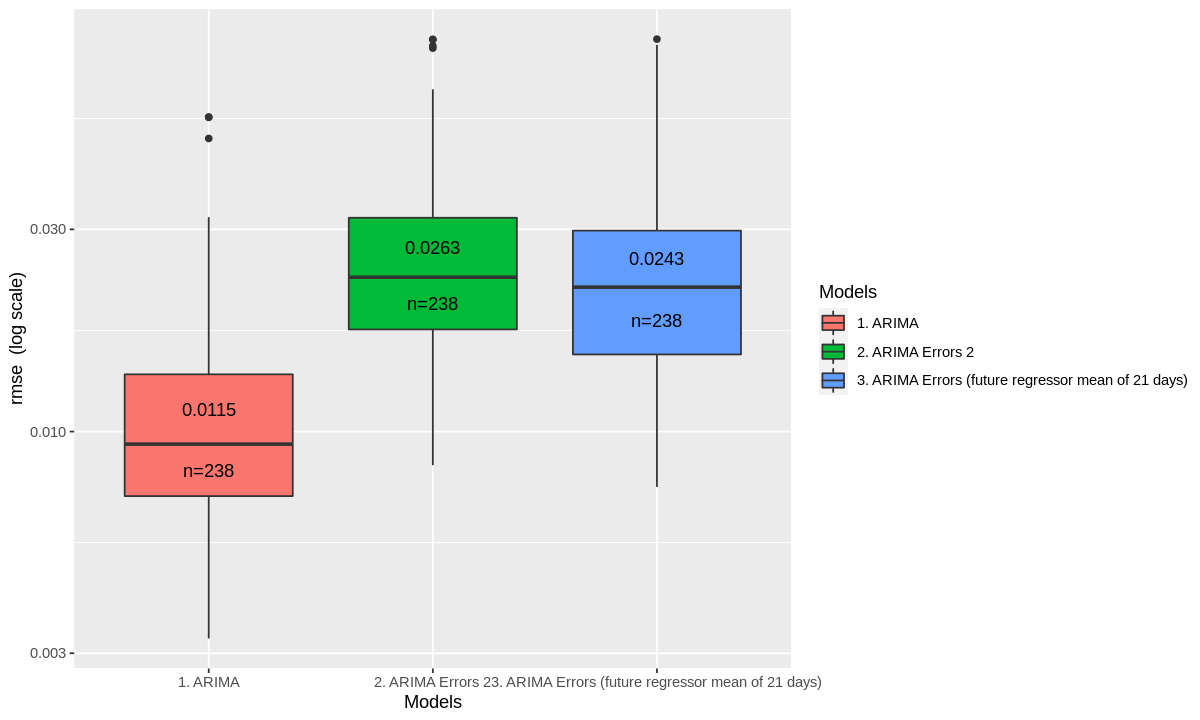

In [26]:
errors.1 <- new.get_result(result.m03.1, '1. ARIMA')
errors.2 <- new.get_result(result.m03.2, '2. ARIMA Errors 2')
n <- paste('3. ARIMA Errors (future regressor mean of', hori ,'days)', sep=' ')
errors.3 <- new.get_result(result.m03.3, n)

x <- rbind(errors.1, errors.2)
x <- rbind(x, errors.3)

new.plot_errors(x, ylog=T)

### save result

In [27]:
x <- result.m03.1
write.csv(x, file = "arima_result_m0301.csv")
x <- result.m03.2
write.csv(x, file = "arima_result_m0302.csv")
x <- result.m03.3
write.csv(x, file = "arima_result_m0303.csv")

### load result

In [25]:
result.m03.1 <- read.csv(file = 'arima_result_m0301.csv')
result.m03.2 <- read.csv(file = 'arima_result_m0302.csv')
result.m03.3 <- read.csv(file = 'arima_result_m0303.csv')

In [27]:
result.m03 <- result.m03.1

# ARIMA+GARCH

## Setting

In [53]:
cv.forecast <- function(x, h, 
                        mxreg=NULL, mxreg.msize=NULL, 
                        vxreg=NULL, vxreg.msize=NULL,
                        order=NULL) {
    forc <- ag2.forecast(x, h, 
                         mxreg=mxreg, mxreg.msize=mxreg.msize, 
                         vxreg=vxreg, vxreg.msize=vxreg.msize, 
                         out.sample=0, order=order)
    if (!is.na(forc)) {
        fc <- list(method = "ARIMA+GARCH Forecasting", mean=forc@forecast$seriesFor[,1],
                   arima.order=forc@users$arima.order)
        attr(fc$mean, "names") <- NULL
        return(fc)
    }
}

agarch.forecast <- cv.forecast

In [17]:
cv.forecast.2 <- function(x, h, 
                          mxreg=NULL, mxreg.msize=NULL, 
                          vxreg=NULL, vxreg.msize=NULL, 
                          sample.n=0) 
{
    result.rmse <- c()
    result.mape <- c()
    train.len <- length(x) - h
    my.subset <- function(x, s, e) {
        if (!is.null(x)) {
            x <- subset(ts(x), start=s, end=e)
        }
        return(x)
    }
    idx <- 0:(h-1)
    if ((sample.n>0) & (sample.n<h)) {
        idx <- sort(sample(idx, sample.n))
    }
    
    order <- NULL
    for (i in seq_along(idx)) {
        trlen <- train.len+idx[i]
        x.train <- my.subset(x, 1, trlen)
        mxreg.train <- my.subset(mxreg, 1, trlen)
        vxreg.train <- my.subset(vxreg, 1, trlen)
        
        fc <- cv.forecast(x.train, 1, 
                          mxreg=mxreg.train, mxreg.msize=mxreg.msize, 
                          vxreg=vxreg.train, vxreg.msize=vxreg.msize, 
                          order=order)
        if (i==1) { # reuse param for the rest of periods
            order <- fc$arima.order
        }
        
        result.rmse[i] <- sqrt(mean((fc$mean - x[trlen+1])^2))
        result.mape[i] <- mean(abs(1 - fc$mean / x[trlen+1]))
    }
    e <- list(rmse.mean=mean(result.rmse), rmse.sigma=sd(result.rmse), 
              mape.mean=mean(result.mape), mape.sigma=sd(result.mape))
    return(e)
} 

## Basic

In [18]:
result.m04.1 <- my.tsCV.2(train, cv.forecast.2, h=hori, window=wind, step=peri,
                          silent=F,
                          sample.n=round(hori*sample.r))

[1] "10 % done."
[1] "20 % done."
[1] "30 % done."
[1] "GARCH model does not converge"
[1] "40 % done."
[1] "GARCH model does not converge"
[1] "GARCH model does not converge"
[1] "GARCH model does not converge"
[1] "GARCH model does not converge"
[1] "50 % done."
[1] "GARCH model does not converge"
[1] "GARCH model does not converge"
[1] "GARCH model does not converge"
[1] "GARCH model does not converge"
[1] "GARCH model does not converge"
[1] "60 % done."
[1] "GARCH model does not converge"
[1] "GARCH model does not converge"
[1] "70 % done."
[1] "GARCH model does not converge"
[1] "GARCH model does not converge"
[1] "GARCH model does not converge"
[1] "80 % done."
[1] "90 % done."
[1] "GARCH model does not converge"
[1] "GARCH model does not converge"


## Regressors for mean

In [19]:
result.m04.2 <- my.tsCV.2(trainx[,1], cv.forecast.2, h=hori, window=wind, step=peri,
                          mxreg=trainx[,2:4], silent=F,
                          sample.n=round(hori*sample.r))

[1] "10 % done."
[1] "20 % done."
[1] "30 % done."
[1] "40 % done."
[1] "GARCH model does not converge"
[1] "50 % done."
[1] "60 % done."
[1] "70 % done."
[1] "80 % done."
[1] "90 % done."


## Regressors for variance

In [20]:
result.m04.3 <- my.tsCV.2(trainx[,1], cv.forecast.2, h=hori, window=wind, step=peri,
                          vxreg=trainx[,2:4], silent=F,
                          sample.n=round(hori*sample.r))

[1] "10 % done."
[1] "20 % done."
[1] "30 % done."
[1] "40 % done."
[1] "50 % done."
[1] "60 % done."
[1] "70 % done."
[1] "GARCH model does not converge"
[1] "GARCH model does not converge"
[1] "80 % done."
[1] "GARCH model does not converge"
[1] "90 % done."
[1] "GARCH model does not converge"
[1] "GARCH model does not converge"


## Regressors for both of mean & variance

In [21]:
result.m04.4 <- my.tsCV.2(trainx[,1], cv.forecast.2, h=hori, window=wind, step=peri,
                          mxreg=trainx[,2:4], vxreg=trainx[,2:4], 
                          silent=F,
                          sample.n=round(hori*sample.r))

[1] "10 % done."
[1] "GARCH model does not converge"
[1] "20 % done."
[1] "30 % done."
[1] "40 % done."
[1] "50 % done."
[1] "60 % done."
[1] "70 % done."
[1] "80 % done."
[1] "90 % done."


In [22]:
x <- result.m04.4
from <- x[!is.na(x[,'forecast_start']),][,1][1]
from <- index(trainx[from])
print(paste('cv starts from', from, sep=' '))

[1] "cv starts from 2000-02-09"


## Compare Errors

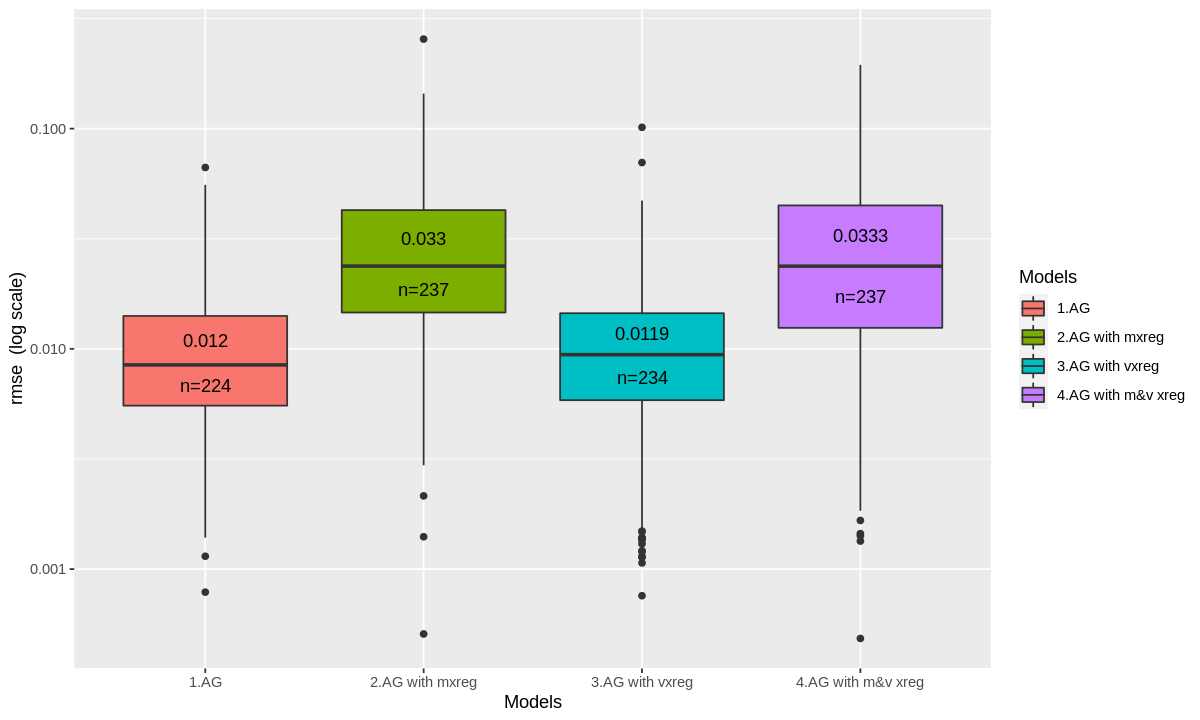

In [29]:
errors.1 <- new.get_result(result.m04.1, '1.AG')
errors.2 <- new.get_result(result.m04.2, '2.AG with mxreg')
errors.3 <- new.get_result(result.m04.3, '3.AG with vxreg')
errors.4 <- new.get_result(result.m04.4, '4.AG with m&v xreg')

x <- rbind(errors.1, errors.2)
x <- rbind(x, errors.3)
x <- rbind(x, errors.4)

new.plot_errors(x, ylog=T)

### save result

In [31]:
x <- result.m04.1
write.csv(x, file = "agarch_result_m0401.csv")
x <- result.m04.2
write.csv(x, file = "agarch_result_m0402.csv")
x <- result.m04.3
write.csv(x, file = "agarch_result_m0403.csv")
x <- result.m04.4
write.csv(x, file = "agarch_result_m0404.csv")

### load result

In [28]:
result.m04.1 <- read.csv(file = 'agarch_result_m0401.csv')
result.m04.2 <- read.csv(file = 'agarch_result_m0402.csv')
result.m04.3 <- read.csv(file = 'agarch_result_m0403.csv')
result.m04.4 <- read.csv(file = 'agarch_result_m0404.csv')

In [30]:
result.m04 <- result.m04.3

# Model Comparision

In [39]:
errors.1 <- new.get_result(result.m01, '1. Prophet')
errors.2 <- new.get_result(result.m02, '2. BSTS')
errors.3 <- new.get_result(result.m03, '3. ARIMA')
errors.4 <- new.get_result(result.m04, '4. ARIMA+GARCH')

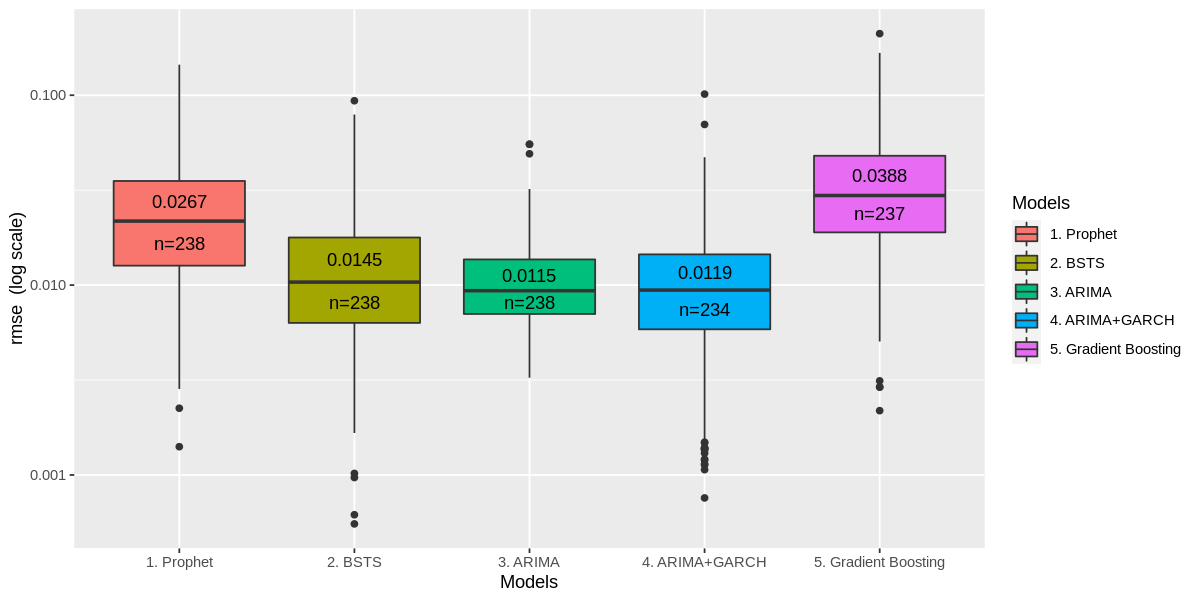

In [41]:
errors.list <- list(errors.1, errors.2, errors.3, errors.4)
x <- errors.list[[1]]
for (e in errors.list[2:length(errors.list)]) {
    x <- rbind(x, e)
}

my.figsize(10, 5)
new.plot_errors(x, ylog=T)

In [ ]:
write.csv(x, file = "result_comparison.csv")

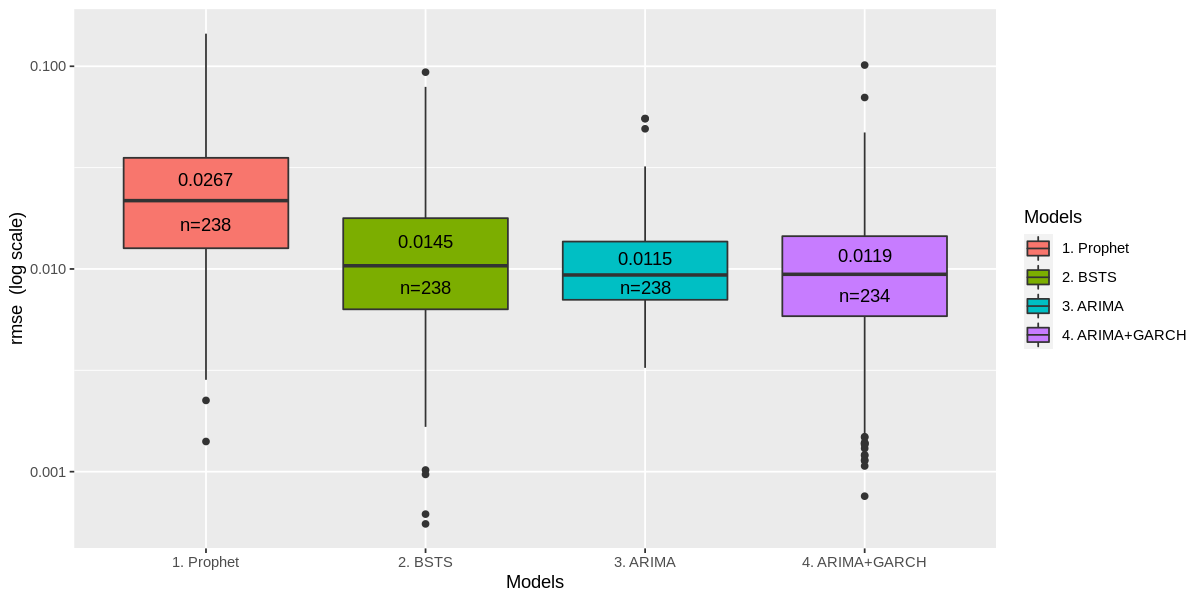

In [17]:
x <- read.csv(file = 'result_comparison.csv')
my.figsize(10, 5)
new.plot_errors(x, ylog=T)

In [16]:
nrow(x)
#head(x)
x2 <- x[x[,'Models']!='5. Gradient Boosting',]
nrow(x2)
write.csv(x2, file = "result_comparison.csv")

[1] 1185

[1] 948

## Forecast with best model

In [276]:
h <- 21
x.train <- train[1:wind]
x.test <- train[(wind+1):(wind+h)]

In [277]:
my.figsize(10,5)


 Fitting models using approximations to speed things up...

 ARIMA(2,0,2) with non-zero mean : Inf
 ARIMA(0,0,0) with non-zero mean : -8729.901
 ARIMA(1,0,0) with non-zero mean : -13486.9
 ARIMA(0,0,1) with non-zero mean : -10820.55
 ARIMA(0,0,0) with zero mean     : -8407.697
 ARIMA(2,0,0) with non-zero mean : -13491.63
 ARIMA(3,0,0) with non-zero mean : -13491.75
 ARIMA(4,0,0) with non-zero mean : -13496.44
 ARIMA(5,0,0) with non-zero mean : -13502.01
 ARIMA(5,0,1) with non-zero mean : -13509.96
 ARIMA(4,0,1) with non-zero mean : -13504.29
 ARIMA(5,0,2) with non-zero mean : -13507.99
 ARIMA(4,0,2) with non-zero mean : -13508.66
 ARIMA(5,0,1) with zero mean     : -13497.02

 Now re-fitting the best model(s) without approximations...

 ARIMA(5,0,1) with non-zero mean : -13497.21

 Best model: ARIMA(5,0,1) with non-zero mean 



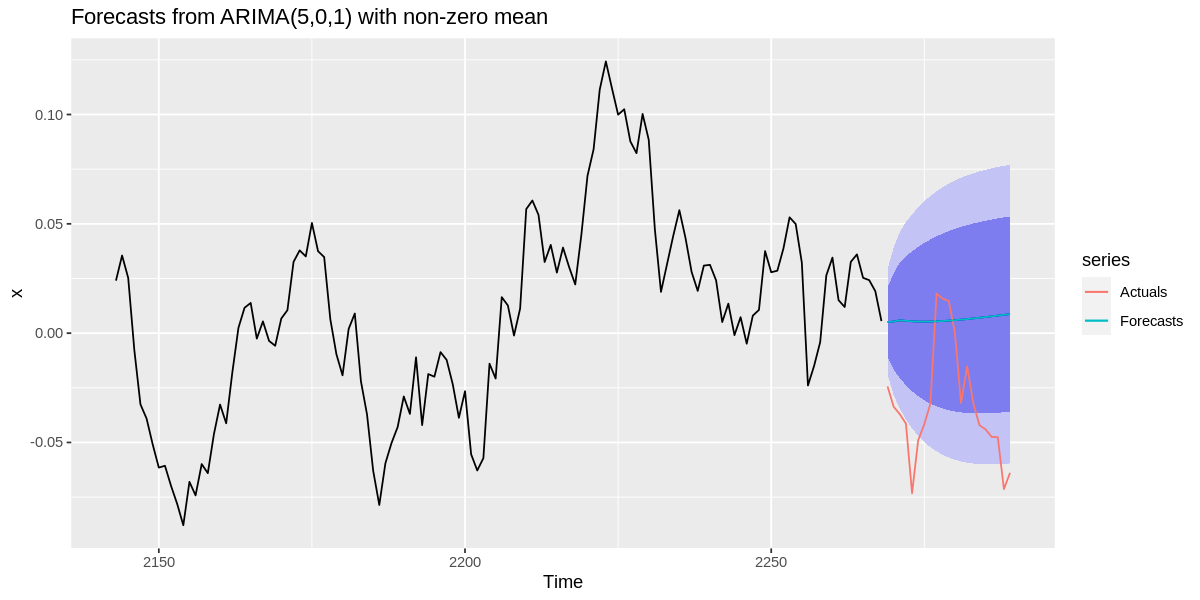

In [278]:
fc <- arima.forecast(x.train, h)
my.plot_forecast(fc, future=h, test=x.test, past=h*6)

=-=-=-=-= Iteration 0 Sun Sep 25 22:37:25 2022 =-=-=-=-=
=-=-=-=-= Iteration 100 Sun Sep 25 22:37:29 2022 =-=-=-=-=
=-=-=-=-= Iteration 200 Sun Sep 25 22:37:33 2022 =-=-=-=-=
=-=-=-=-= Iteration 300 Sun Sep 25 22:37:37 2022 =-=-=-=-=
=-=-=-=-= Iteration 400 Sun Sep 25 22:37:41 2022 =-=-=-=-=
=-=-=-=-= Iteration 500 Sun Sep 25 22:37:45 2022 =-=-=-=-=
=-=-=-=-= Iteration 600 Sun Sep 25 22:37:49 2022 =-=-=-=-=
=-=-=-=-= Iteration 700 Sun Sep 25 22:37:53 2022 =-=-=-=-=
=-=-=-=-= Iteration 800 Sun Sep 25 22:37:57 2022 =-=-=-=-=
=-=-=-=-= Iteration 900 Sun Sep 25 22:38:01 2022 =-=-=-=-=


NULL

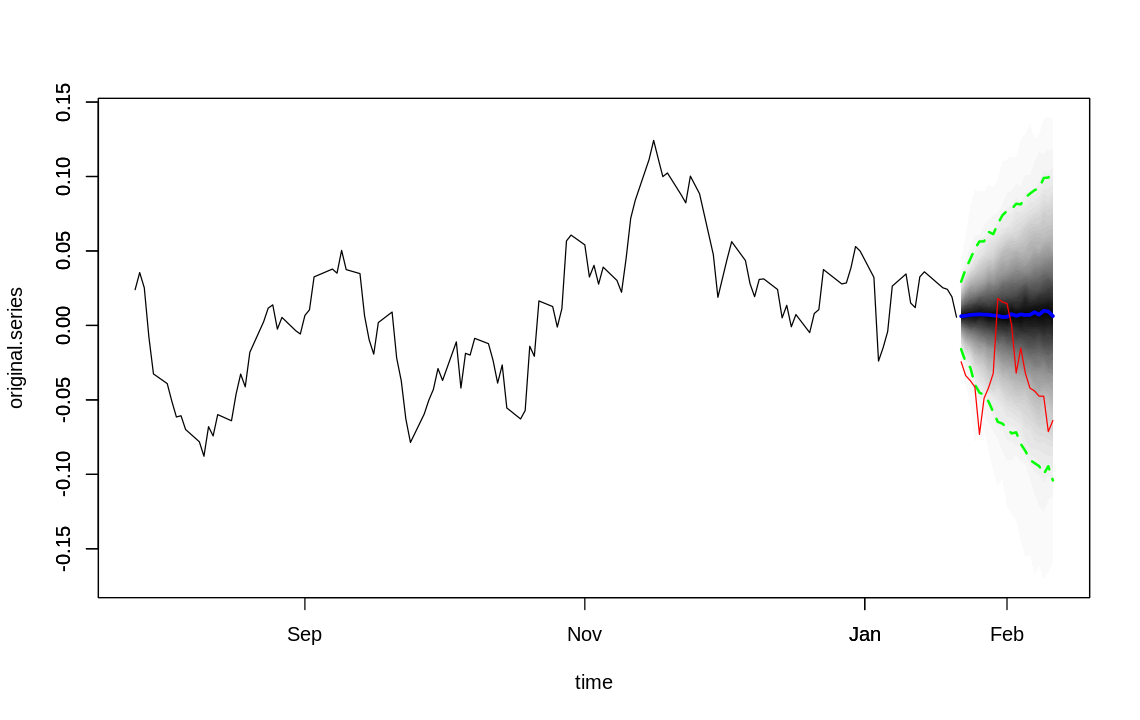

In [279]:
bsts.lines <- function(fc, obs, ...) {
    n1 <- ncol(fc$distribution)
    time <- index(fc$original.series)
    deltat <- tail(diff(tail(time, 2)), 1)
    pred.time <- tail(time, 1) + (1:n1) * deltat
    obs <- obs[1:length(pred.time)]
    index(obs) <- pred.time
    #l <- lines(obs)
    l <- lines(pred.time, as.numeric(obs), ...)
    return(l)
}

fc <- bsts.forecast(x.train, h)

my.figsize(9.5,6)
plot(fc, plot.original=h*6)
bsts.lines(fc, x.test, col='red')